In [1]:
from __future__ import print_function
from __future__ import division

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df =pd.read_csv('./feature_set.csv')

In [3]:
df.head()

,Number_of_Workers,Number_of_partial_siddhi_apps,DataRate,No of String Attributes in input Stream,No of float Attributes in input Stream,No of double Attributes in input Stream,No of int Attributes in input Stream,No of long Attributes in input Stream,ExternalTmeWindowSize(Sec),ExternalTimeBatch,...,Aggregation function,In built functions,No of Select Operations,No of Insert Operators,No of From operators,Inner Streams,No of string extensions,No of email processor extensions,No of filter conditions,Throughput
0,3,3,3,4,7,2,1,2,30,0,...,3,3,4,4,4,2,0,0,1,209.105079
1,3,6,3,4,7,2,1,2,30,0,...,3,3,4,4,4,2,0,0,1,403.098494
2,3,9,3,4,7,2,1,2,30,0,...,3,3,4,4,4,2,0,0,1,515.373114
3,3,18,3,4,7,2,1,2,30,0,...,3,3,4,4,4,2,0,0,1,717.240405
4,4,4,3,4,7,2,1,2,30,0,...,3,3,4,4,4,2,0,0,1,245.984533


In [4]:
print('LogProcessor 3')
print('Mean:',df['Throughput'].mean())
print('Variance:',df['Throughput'].var())

LogProcessor 3
Mean: 424.516716065
Variance: 55858.65627033654


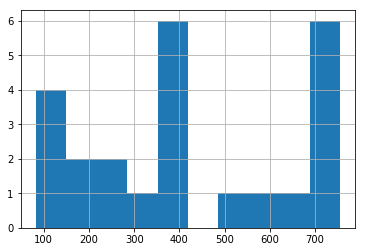

In [5]:
df['Throughput'].hist()

In [6]:
correlations = df.corr()

Text(0.5, 1.0, 'Logprocessor3 Variable Correlations')

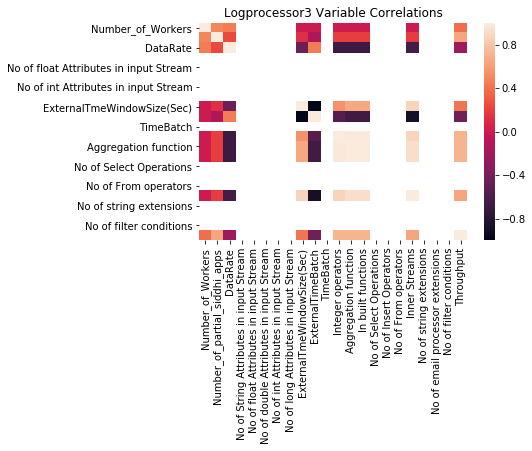

In [7]:
# plot logprocessor
corr_heat = sns.heatmap(correlations)
plt.title('Logprocessor3 Variable Correlations')

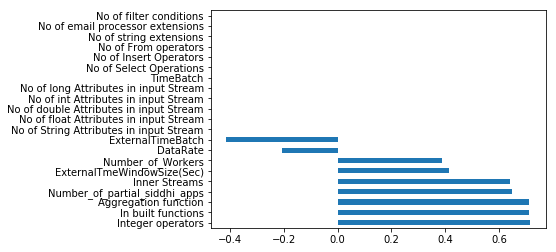

In [8]:
# San Juan
(correlations
     .Throughput
     .drop('Throughput') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [9]:
def preprocess_data(data_path, labels_path=None):
    df = pd.read_csv(data_path)
    
    # select features we want
    features = ['Number_of_Workers',
                'Number_of_partial_siddhi_apps',
                'Integer operators',
                'Aggregation function'
               ]
    df = df[features]
# fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path)
        return df,labels
        #df = df.join(labels)
    
    return df,labels

In [10]:
df,labels = preprocess_data('./feature_set_normalized.csv','./labels.csv')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=123)

In [12]:
# Labels are the values we want to predict
labels = np.array(labels)

In [13]:
features = np.array(df)

In [14]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (19, 4)
Training Labels Shape: (19, 1)
Testing Features Shape: (5, 4)
Testing Labels Shape: (5, 1)


In [16]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, max_depth=5,random_state=40)
# Train the model on training data
rf.fit(train_features, train_labels);

In [17]:
predictions_random_forest = rf.predict(test_features)

In [18]:
root_mean_squared_error_random_forest = mean_squared_error(test_labels, predictions_random_forest)**0.5
print("root_mean_squared_error_random_forest: %f" % (root_mean_squared_error_random_forest))

root_mean_squared_error_random_forest: 118.270336


In [19]:
regressor = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.4, max_depth = 5, alpha = 10, n_estimators = 1000)
regressor.fit(X_train, y_train)

predictions_XGBoost = regressor.predict(X_test)

In [20]:
test_labels

array([[739.122153],
       [376.453025],
       [209.105079],
       [135.298582],
       [680.369361]])

In [21]:
root_mean_squared_error_XGBoost = mean_squared_error(test_labels, predictions_XGBoost)**0.5
print("root_mean_squared_error_XGBoost: %f" % (root_mean_squared_error_XGBoost))

root_mean_squared_error_XGBoost: 107.585907


In [22]:
print("Make predictions on the test set")
test_probs = (predictions_random_forest + predictions_XGBoost)/2

Make predictions on the test set


In [23]:
root_mean_squared_error = mean_squared_error(test_labels, test_probs)**0.5
print("root_mean_squared_error: %f" % (root_mean_squared_error))

root_mean_squared_error: 65.750859


In [29]:
def percentage_error(y_true, y_pred):
    return (np.abs((y_true.mean() - y_pred.mean()) / y_true.mean())) * 100

print("Calculated percentage rmse =","%.2f"%(percentage_error(test_labels, test_probs)),"%")

Calculated percentage rmse = 11.93 %


In [25]:
print("Accuracy =","%.2f"% (100-percentage_error(test_labels, test_probs)),"%")

Accuracy = 88.07 %
